<a href="https://colab.research.google.com/github/Anmoljain2005/Image_Colorisation/blob/main/Image_Colorisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install fastai==2.4

INFO: pip is looking at multiple versions of fastai to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch<1.10,>=1.7.0 (from fastai) (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1)
ERROR: No matching distribution found for torch<1.10,>=1.7.0


In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

In [ ]:
paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 10000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


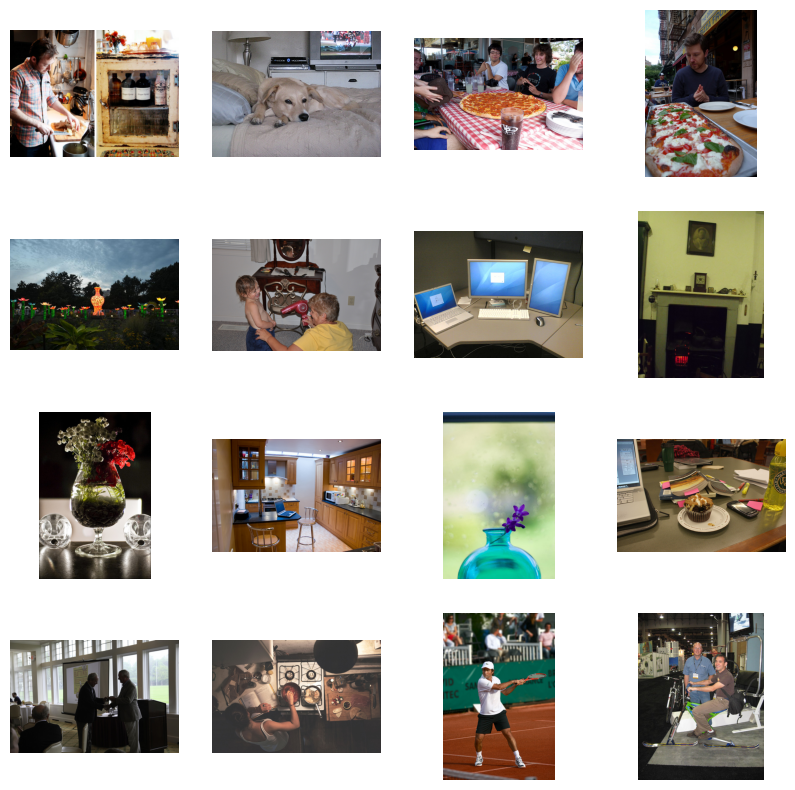

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1.
        ab = img_lab[[1, 2], ...] / 110.

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


In [ ]:
class SimpleUNet(nn.Module):
    def __init__(self, input_c=1, output_c=2):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_c, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, output_c, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c=3, num_filters=64):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_c, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_filters * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_filters * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_filters * 4, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla'):
        super(GANLoss, self).__init__()
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def forward(self, preds, target_is_real):
        if target_is_real:
            labels = torch.ones_like(preds)
        else:
            labels = torch.zeros_like(preds)
        return self.loss(preds, labels)

In [ ]:
def train_gan(generator, discriminator, train_dl, opt_G, opt_D, criterion_GAN, criterion_L1, device, epochs=20, lambda_L1=100):
    generator.to(device)
    discriminator.to(device)
    for epoch in range(epochs):
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            real_images = torch.cat([L, ab], dim=1)

            # Train Discriminator
            opt_D.zero_grad()
            fake_ab = generator(L).detach()
            fake_images = torch.cat([L, fake_ab], dim=1)

            real_preds = discriminator(real_images)
            fake_preds = discriminator(fake_images)

            loss_D_real = criterion_GAN(real_preds, True)
            loss_D_fake = criterion_GAN(fake_preds, False)
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            opt_D.step()

            # Train Generator
            opt_G.zero_grad()
            fake_ab = generator(L)
            fake_images = torch.cat([L, fake_ab], dim=1)
            fake_preds = discriminator(fake_images)

            loss_G_GAN = criterion_GAN(fake_preds, True)
            loss_G_L1 = criterion_L1(fake_ab, ab) * lambda_L1
            loss_G = loss_G_GAN + loss_G_L1
            loss_G.backward()
            opt_G.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss_D: {loss_D.item()}, Loss_G: {loss_G.item()}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_G = SimpleUNet(input_c=1, output_c=2)
net_D = PatchDiscriminator(input_c=3)
opt_G = optim.Adam(net_G.parameters(), lr=1e-4)
opt_D = optim.Adam(net_D.parameters(), lr=1e-4)

criterion_GAN = GANLoss(gan_mode='vanilla').to(device)
criterion_L1 = nn.L1Loss()

# Train the GAN model
train_gan(net_G, net_D, train_dl, opt_G, opt_D, criterion_GAN, criterion_L1, device, epochs=20)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/20, Loss_D: 0.24147984385490417, Loss_G: 15.623952865600586


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/20, Loss_D: 0.49914610385894775, Loss_G: 13.135345458984375


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/20, Loss_D: 0.5270630717277527, Loss_G: 13.563766479492188


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/20, Loss_D: 0.0025875226128846407, Loss_G: 19.47707176208496


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/20, Loss_D: 0.16714000701904297, Loss_G: 15.959729194641113


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/20, Loss_D: 0.0026704929769039154, Loss_G: 18.970020294189453


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/20, Loss_D: 0.0006158385658636689, Loss_G: 18.747547149658203


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/20, Loss_D: 0.005531155504286289, Loss_G: 19.939306259155273


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/20, Loss_D: 0.03414415195584297, Loss_G: 15.153797149658203


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/20, Loss_D: 0.2651812732219696, Loss_G: 14.0739107131958


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/20, Loss_D: 0.6480152606964111, Loss_G: 13.337894439697266


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/20, Loss_D: 0.19885028898715973, Loss_G: 15.875792503356934


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/20, Loss_D: 0.3915542960166931, Loss_G: 13.344295501708984


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/20, Loss_D: 0.3746297061443329, Loss_G: 13.64834976196289


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/20, Loss_D: 0.3697740435600281, Loss_G: 13.156427383422852


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/20, Loss_D: 0.20582042634487152, Loss_G: 15.895121574401855


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/20, Loss_D: 0.36462247371673584, Loss_G: 14.129963874816895


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/20, Loss_D: 0.5611546039581299, Loss_G: 13.642436027526855


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/20, Loss_D: 0.26230907440185547, Loss_G: 12.728473663330078


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/20, Loss_D: 0.18369781970977783, Loss_G: 14.314193725585938


In [ ]:
# Function to get a specific image from the DataLoader
def get_nth_image(data_loader, n):
    current_index = 0
    for batch_data in data_loader:
        batch_size = batch_data['L'].size(0)
        if current_index + batch_size > n:
            # Get the (n - current_index)-th image from this batch
            return {key: val[n - current_index:n - current_index + 1] for key, val in batch_data.items()}
        current_index += batch_size
    raise IndexError(f"Index {n} is out of range for the dataset")

  # Modified visualize function to visualize the specific image
def visualize_nth_image(generator, data_loader, n, device):
    data = get_nth_image(data_loader, n)  # Get the nth image
    generator.eval()
    with torch.no_grad():
        L, ab_real = data['L'].to(device), data['ab'].to(device)
        preds = generator(L)

        # Rescale L and ab for visualization
        L_rescaled = (L + 1) * 50  # Rescale L to [0, 100]
        ab_fake_rescaled = preds * 110  # Rescale fake ab to original range
        ab_real_rescaled = ab_real * 110  # Rescale real ab to original range

        # Combine L with predicted ab and real ab
        img_lab_fake = torch.cat([L_rescaled, ab_fake_rescaled], dim=1).permute(0, 2, 3, 1).cpu().numpy()
        img_lab_real = torch.cat([L_rescaled, ab_real_rescaled], dim=1).permute(0, 2, 3, 1).cpu().numpy()

        # Convert LAB images to RGB
        img_rgb_fake = lab2rgb(img_lab_fake[0])
        img_rgb_real = lab2rgb(img_lab_real[0])

        # Plot grayscale input, real colored image, and generated colored image
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(L_rescaled[0, 0].cpu(), cmap='gray')  # Grayscale input
        axs[0].set_title("Grayscale Input")
        axs[0].axis('off')

        axs[1].imshow(img_rgb_real)  # Real colored image (ground truth)
        axs[1].set_title("Real Color Image")
        axs[1].axis('off')

        axs[2].imshow(img_rgb_fake)  # Generated colored image
        axs[2].set_title("Generated Color Image")
        axs[2].axis('off')

        plt.show()

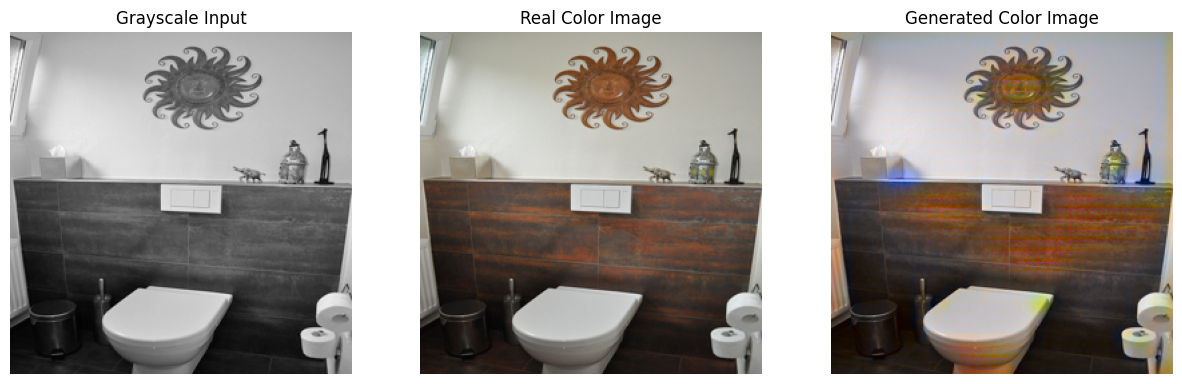

In [69]:
visualize_nth_image(net_G, val_dl, 151, device)

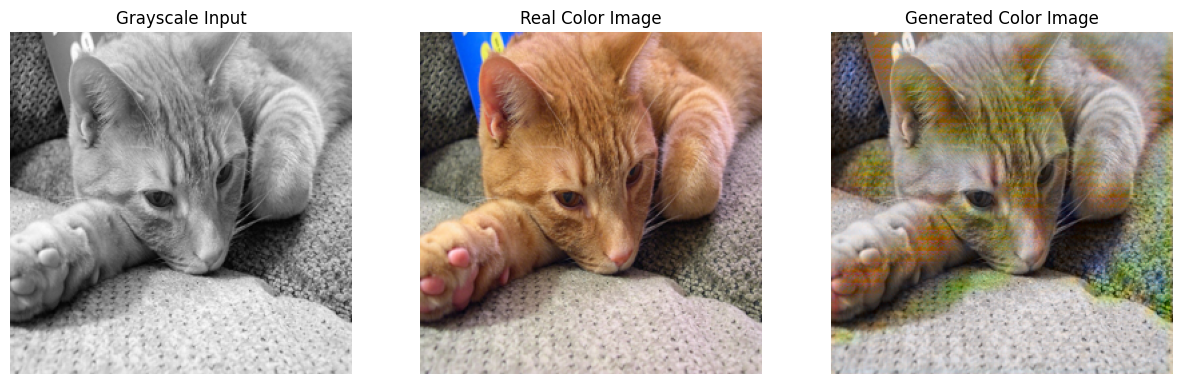

In [ ]:
visualize_nth_image(net_G, val_dl, 58, device)

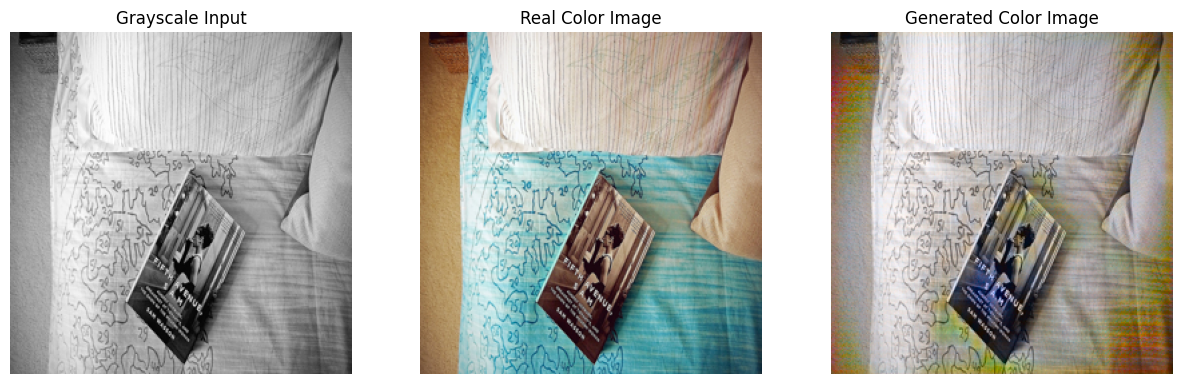

In [ ]:
visualize_nth_image(net_G, val_dl, 109, device)

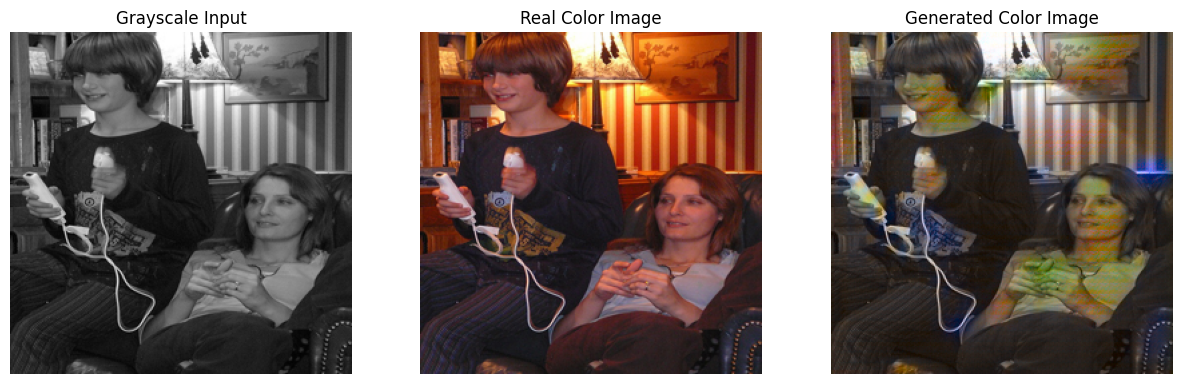

In [ ]:
visualize_nth_image(net_G, val_dl, 765, device)

<ipython-input-49-971902c481e1>:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  img_rgb_fake = lab2rgb(img_lab_fake[0])


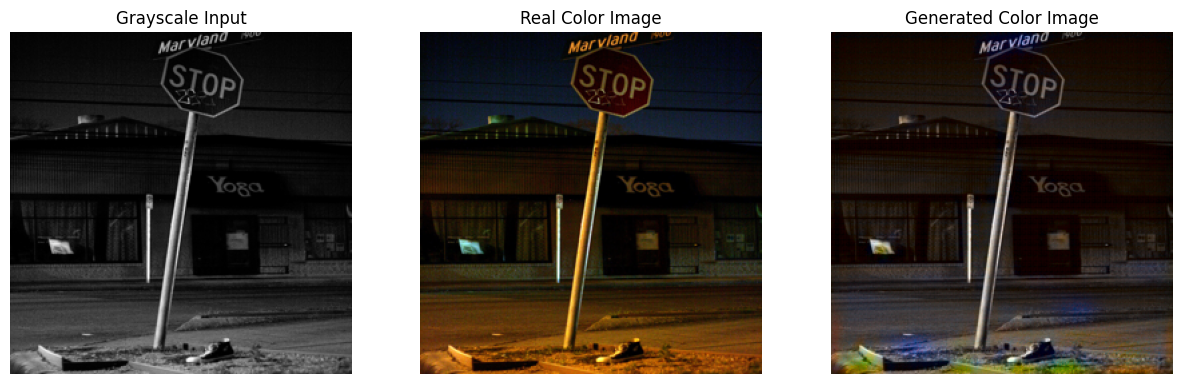

In [ ]:
visualize_nth_image(net_G, val_dl, 193, device)

<ipython-input-40-59e58a2e1d43>:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  img_rgb_fake = lab2rgb(img_lab_fake[0])  # Note the use of [0] to select the first image


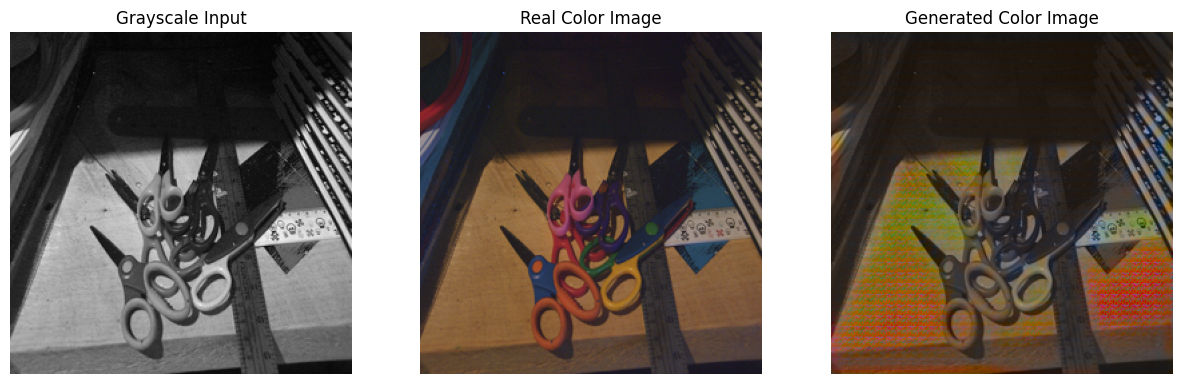

In [ ]:
visualize_nth_image(net_G, val_dl, 678, device)

<ipython-input-40-59e58a2e1d43>:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 33 negative Z values that have been clipped to zero
  img_rgb_fake = lab2rgb(img_lab_fake[0])  # Note the use of [0] to select the first image


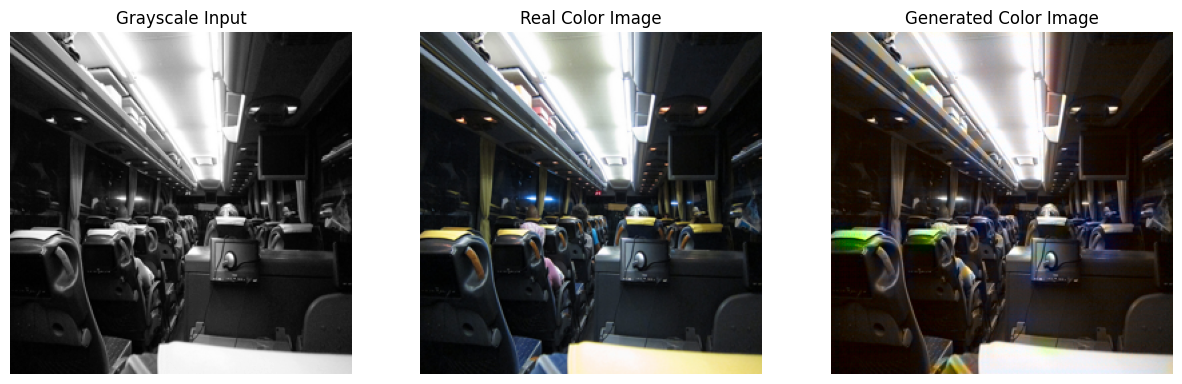

In [ ]:
visualize_nth_image(net_G, val_dl, 93, device)

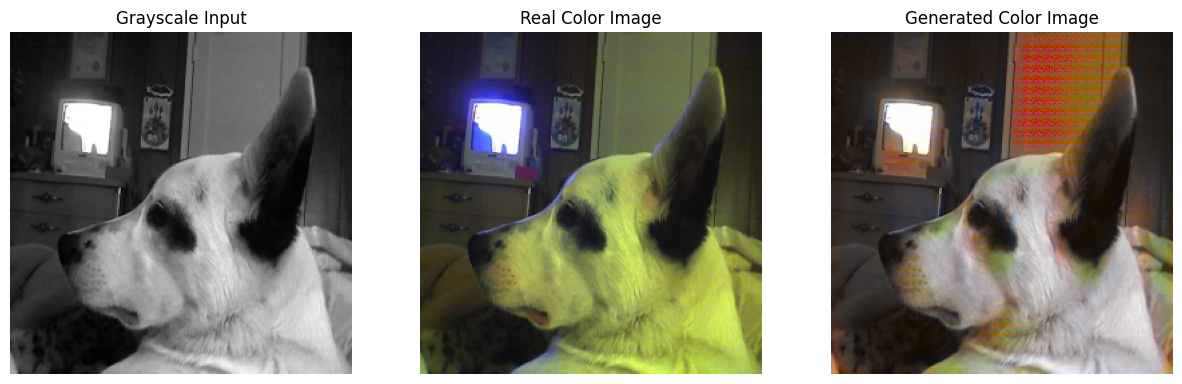

In [ ]:
visualize_nth_image(net_G, val_dl, 78, device)

<ipython-input-49-971902c481e1>:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 50 negative Z values that have been clipped to zero
  img_rgb_fake = lab2rgb(img_lab_fake[0])


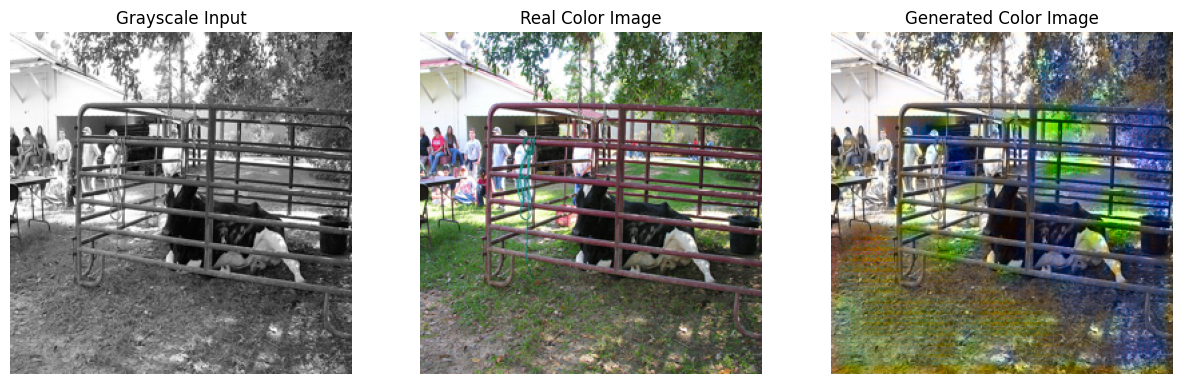

In [ ]:
visualize_nth_image(net_G, val_dl, 1578, device)

<ipython-input-49-971902c481e1>:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb_fake = lab2rgb(img_lab_fake[0])


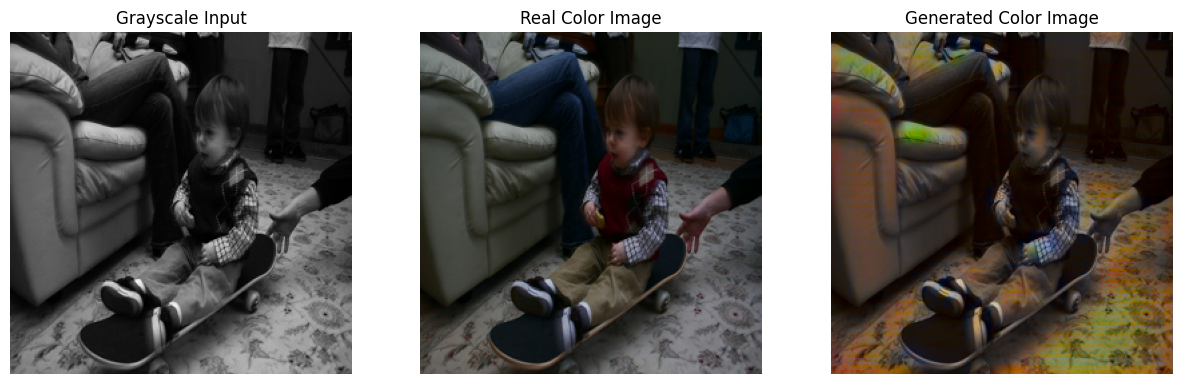

In [68]:
visualize_nth_image(net_G, val_dl, 188, device)